In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Info

In [143]:
df1 = pd.read_csv("../data/wikidata_artists_part1.csv")
df2= pd.read_csv("../data/wikidata_artists_part2.csv")

df = pd.concat([df1, df2], ignore_index=True)
df.head()

,artist,country,type,genre,award,birth,death,gender
0,13,NaN,album,new wave,álbum,NaN,NaN,Unknown
1,13,NaN,album,new wave,album de diamant du SNEP,NaN,NaN,Unknown
2,13,NaN,album,new wave,תואר יהלום מ-SNEP,NaN,NaN,Unknown
3,13,NaN,album,new wave,diamantalbum enligt SNEP,NaN,NaN,Unknown
4,13,NaN,album,new wave,diamantni album SNEP,NaN,NaN,Unknown


In [144]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1029557 entries, 0 to 1029556
Data columns (total 8 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   artist   1029557 non-null  object
 1   country  867348 non-null   object
 2   type     1029557 non-null  object
 3   genre    926248 non-null   object
 4   award    1029557 non-null  object
 5   birth    868474 non-null   object
 6   death    335799 non-null   object
 7   gender   1029557 non-null  object
dtypes: object(8)
memory usage: 62.8+ MB


In [145]:
df.isnull().sum()

artist          0
country    162209
type            0
genre      103309
award           0
birth      161083
death      693758
gender          0
dtype: int64

In [146]:
df['country'].value_counts()

country
United States     367675
United Kingdom    100718
Canada             41333
France             38695
Soviet Union       37632
                   ...  
Troy                   9
Georgia                9
Ethiopia               8
Ivory Coast            5
Croatia                3
Name: count, Length: 139, dtype: int64

## Nulos

In [147]:
df['country'] = df['country'].fillna('Unknown')

In [148]:
df['death'] = df['death'].notna()  # Convierte valores no nulos en True y los nulos en False
df['death'].value_counts()

death
False    693758
True     335799
Name: count, dtype: int64

In [149]:
df['death'] = df['death'].map({False: 'alive', True: 'deceased'})
df['death'].value_counts()

death
alive       693758
deceased    335799
Name: count, dtype: int64

In [150]:
df['genre'].value_counts()

genre
classical music             64448
pop music                   61765
rock music                  39150
opera                       37079
jazz                        30859
                            ...  
short film                      1
psychological drama film        1
true crime                      1
history book                    1
essay film                      1
Name: count, Length: 812, dtype: int64

In [151]:
df['birth'] = df['birth'].fillna('Unknown')

In [152]:
df = df.drop(columns= ['genre'])

In [153]:
df.isnull().sum()

artist     0
country    0
type       0
award      0
birth      0
death      0
gender     0
dtype: int64

In [154]:
df.head()

,artist,country,type,award,birth,death,gender
0,13,Unknown,album,álbum,Unknown,alive,Unknown
1,13,Unknown,album,album de diamant du SNEP,Unknown,alive,Unknown
2,13,Unknown,album,תואר יהלום מ-SNEP,Unknown,alive,Unknown
3,13,Unknown,album,diamantalbum enligt SNEP,Unknown,alive,Unknown
4,13,Unknown,album,diamantni album SNEP,Unknown,alive,Unknown


## Duplicados

In [155]:
duplicados = df.duplicated()

print(df[duplicados])

               artist  country   type  \
6                  13  Unknown  album   
7                  13  Unknown  album   
8                  13  Unknown  album   
9                  13  Unknown  album   
10                 13  Unknown  album   
...               ...      ...    ...   
1029531  Étienne Daho   France  human   
1029532  Étienne Daho   France  human   
1029533  Étienne Daho   France  human   
1029534  Étienne Daho   France  human   
1029535  Étienne Daho   France  human   

                                                     award  \
6                                                    álbum   
7                                 album de diamant du SNEP   
8                                        תואר יהלום מ-SNEP   
9                                 diamantalbum enligt SNEP   
10                                    diamantni album SNEP   
...                                                    ...   
1029531                         מפקד מסדר האמנויות והספרות   
1029532  Fr

In [156]:
df = df.drop_duplicates()

In [157]:
duplicados = df.duplicated()

print(df[duplicados])

Empty DataFrame
Columns: [artist, country, type, award, birth, death, gender]
Index: []


In [158]:
df.shape

(296267, 7)

In [159]:
repeaated_name = df.value_counts(subset=['artist']).reset_index(name='counts')

# Filtrar solo las combinaciones que aparecen más de una vez
repeated = repeaated_name[repeaated_name['counts'] > 1]

# Mostrar resultados
print("=== Artistas duplicados por 'artists' ===")
print(f"Número de combinaciones duplicadas: {len(repeated)}")
repeated.head(20)

=== Artistas duplicados por 'artists' ===
Número de combinaciones duplicadas: 3150


,artist,counts
0,Mstislav Rostropovich,3332
1,Daniel Barenboim,3303
2,Valery Gergiev,2940
3,Zubin Mehta,2892
4,Ivan Petrov,2768
5,Dmitri Shostakovich,2620
6,Lyudmila Zykina,2016
7,Galina Vishnevskaya,1878
8,Vladimir Fedoseyev,1810
9,Angela Lansbury,1764


## Idioma

In [160]:
import pandas as pd
from langdetect import detect
from tqdm import tqdm

# Frases o palabras comunes en otros idiomas
palabras_no_ingles = [
    "stär um", "para", "prêmio", "premio", "prix", "voor", "de", "sus", "la", "das", "del", "der", "des",
    "el", "le", "pe", "stella", "sulla", "nagroda", "carriera", "réalta", "premi", "xelata",
    "tähti", "æresdoktor", "famen", "doktor", "oriel", "anfarwolion", "auf dem", "or merit", "kpakpando", "stäär üüb"
    
]

# Caché para langdetect
award_lang_cache = {}

def is_english_filtered(text):
    text_l = str(text).lower().strip()
    
    if text not in award_lang_cache:
        try:
            award_lang_cache[text] = detect(text)
        except:
            award_lang_cache[text] = "unknown"
    
    if award_lang_cache[text] != "en":
        return False

    for palabra in palabras_no_ingles:
        if palabra in text_l:
            return False

    return True

# Aplicar el filtro sobre la columna 'award'
tqdm.pandas(desc="🔍 Filtrando premios válidos")
df = df[df['award'].notna() & df['award'].progress_apply(is_english_filtered)]

df.head()


🔍 Filtrando premios válidos:   0%|          | 0/296267 [00:00<?, ?it/s]

🔍 Filtrando premios válidos: 100%|██████████| 296267/296267 [03:08<00:00, 1568.15it/s]


,artist,country,type,award,birth,death,gender
99,1995,Unknown,musical group,Victory of the album of urban musics,Unknown,alive,Unknown
434,50 Cent,United States,human,Billboard Music Awards,1975-07-06T00:00:00Z,alive,male
438,50 Cent,United States,human,Billboard Music Award,1975-07-06T00:00:00Z,alive,male
778,50 Cent,United States,human,star on Hollywood Walk of Fame,1975-07-06T00:00:00Z,alive,male
1012,5 Seconds of Summer,Unknown,musical group,American Music Award for New Artist of the Year,Unknown,alive,Unknown


In [161]:
df.shape

(7935, 7)

### Agrupar premios y creacion de nuevas columnas

In [ ]:

# Función para obtener el valor más común en cada grupo
def valor_mas_comun(serie):
    return serie.mode().iloc[0] if not serie.mode().empty else serie.dropna().iloc[0]

# Agrupar por artista consolidando la información
agrupado = df.groupby("artist").agg({
    "country": valor_mas_comun,
    "type": valor_mas_comun,
    "birth": valor_mas_comun,
    "death": valor_mas_comun,
    "gender": valor_mas_comun,
    "award": lambda x: sorted(set(x))
}).reset_index()

# Crear columna: número de premios
agrupado["award_count"] = agrupado["award"].apply(len)

# Crear columna: si ganó un Grammy (busca "grammy" en los premios)
agrupado["won_grammy"] = agrupado["award"].apply(
    lambda premios: any("grammy" in premio.lower() for premio in premios)
)

# Convertir lista de premios en string separado por punto y coma
agrupado["award"] = agrupado["award"].apply(lambda x: "; ".join(x))

# Asignar al DataFrame final
df = agrupado

# Mostrar resultado
print(df.head())



                 artist        country           type                 birth  \
0                  1995        Unknown  musical group               Unknown   
1   5 Seconds of Summer        Unknown  musical group               Unknown   
2               50 Cent  United States          human  1975-07-06T00:00:00Z   
3  A Tribe Called Quest        Unknown  musical group               Unknown   
4                  ABBA        Unknown  musical group               Unknown   

   death   gender                                              award  \
0  alive  Unknown               Victory of the album of urban musics   
1  alive  Unknown  American Music Award for New Artist of the Yea...   
2  alive     male  Billboard Music Award; Billboard Music Awards;...   
3  alive  Unknown  BRIT Awards/International Group; Brit Award fo...   
4  alive  Unknown  First prize of the Eurovision Song Contest; Ro...   

   award_count  won_grammy  
0            1       False  
1            2       False  
2    

In [167]:
df.shape

(2012, 9)

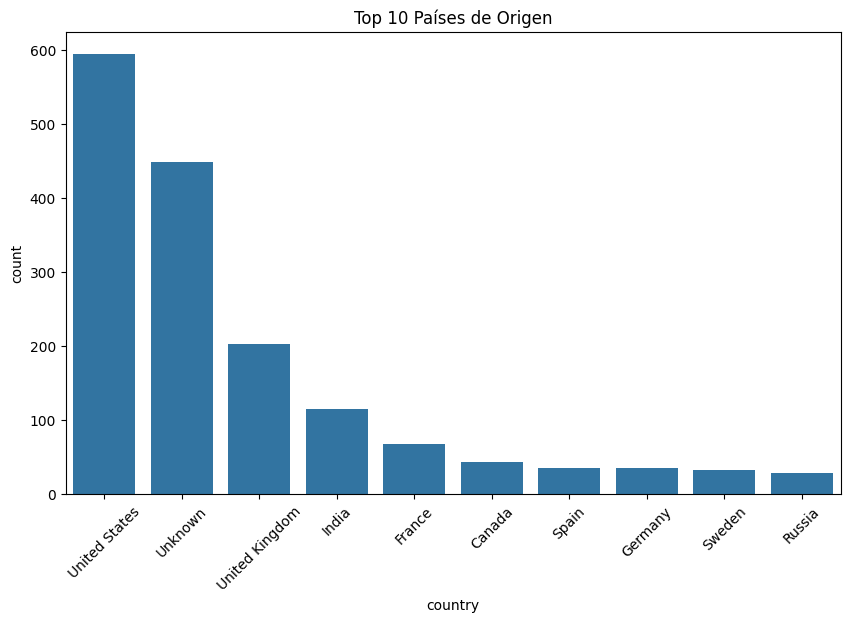

In [168]:
plt.figure(figsize=(10, 6))
sns.countplot(x='country', data=df, order=df['country'].value_counts().index[:10])
plt.title('Top 10 Países de Origen')
plt.xticks(rotation=45)
plt.show()

<Axes: title={'center': 'Top 20 artistas con más premios'}, ylabel='artist'>

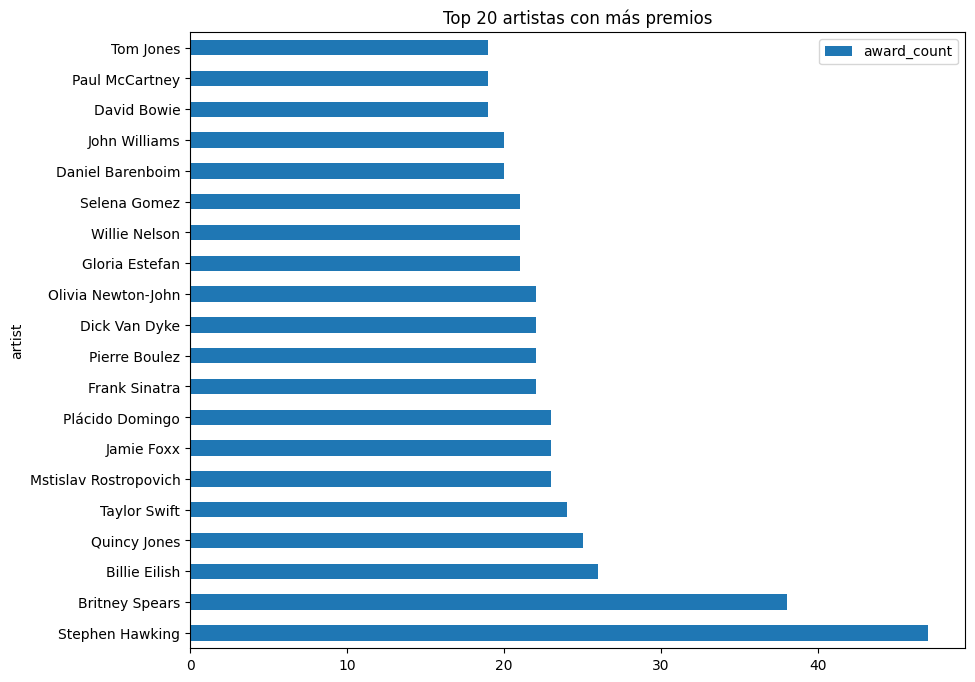

In [169]:
df.sort_values("award_count", ascending=False).head(20).plot.barh(
    x="artist", y="award_count", figsize=(10, 8), title="Top 20 artistas con más premios")


<Axes: title={'center': 'Distribución de premios por artista'}, ylabel='Frequency'>

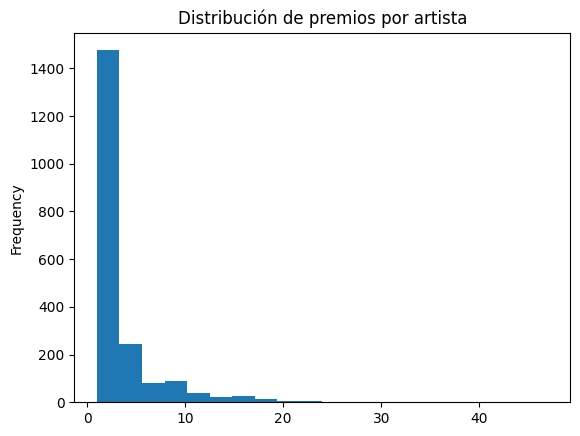

In [170]:
df["award_count"].plot.hist(bins=20, title="Distribución de premios por artista")


<Axes: title={'center': 'Distribución de artistas según premios Grammy'}, ylabel='count'>

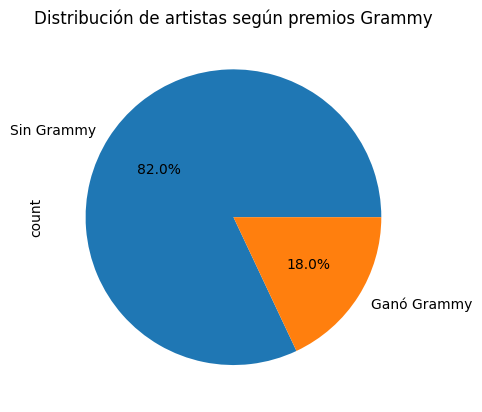

In [171]:
df["won_grammy"].value_counts().plot.pie(autopct='%1.1f%%', labels=["Sin Grammy", "Ganó Grammy"], title="Distribución de artistas según premios Grammy")


<Axes: title={'center': 'Top 10 países con más artistas'}, xlabel='country'>

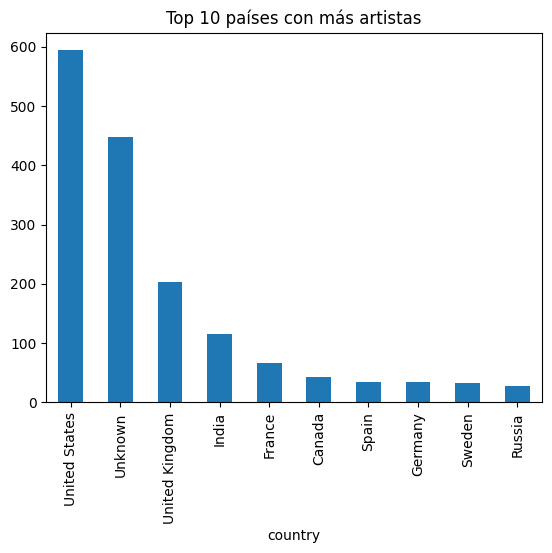

In [172]:
df["country"].value_counts().head(10).plot.bar(title="Top 10 países con más artistas")


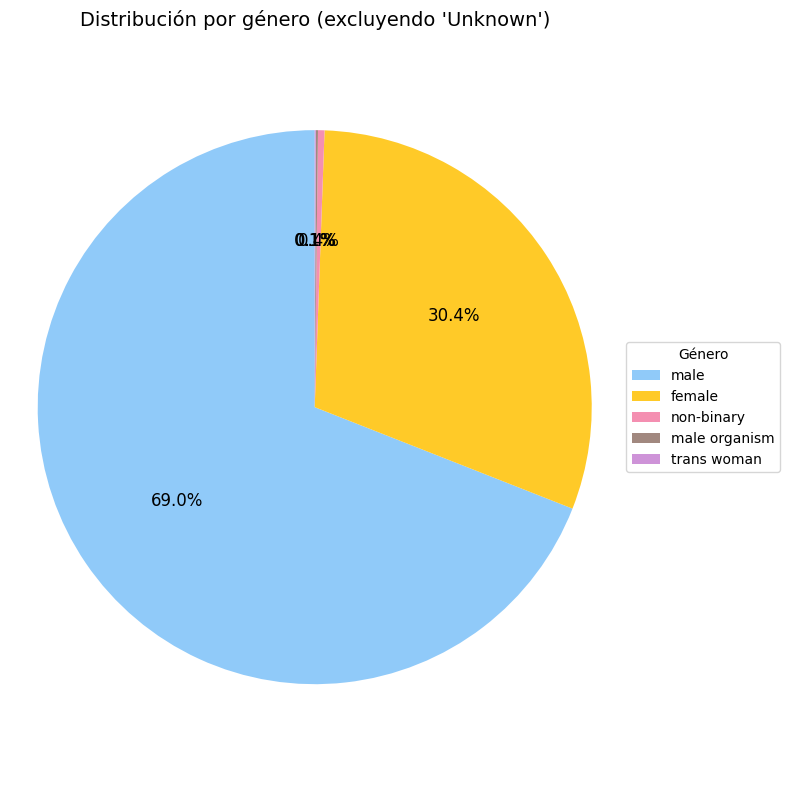

In [ ]:
# Excluir "Unknown"
gender_counts = df[df["gender"] != "Unknown"]["gender"].value_counts()

# Colores personalizados (opcional)
colors = ["#90caf9", "#ffca28", "#f48fb1", "#a1887f", "#ce93d8"]

# Crear figura
plt.figure(figsize=(8, 8))
plt.pie(
    gender_counts,
    labels=None,  # Las quitamos del gráfico
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    textprops={'fontsize': 12}
)
plt.title("Distribución por género (excluyendo 'Unknown')", fontsize=14)
plt.axis("equal")

# Añadir leyenda al costado
plt.legend(
    labels=gender_counts.index,
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    title="Género"
)

plt.tight_layout()
plt.show()

